In [1]:
import time
import ROOT
import numpy as np
import pandas as pd
import root_pandas as rpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from root_pandas import read_root
from math import *
%run functions.ipynb

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.
Welcome to JupyROOT 6.14/06


In [14]:
def getJet(inputFiles):
    
    cols = []
    scalar = []
    
    scalar.append('event')
    scalar.append('njets')
    scalar.append('electron_truthPhi')
    scalar.append('electron_truthPt')
    scalar.append('electron_truthEta')
    scalar.append('electron_truthE')
    
    cols.append('matched_truthNComponent')
    cols.append('nComponent')
    cols.append('pt')
    cols.append('eta')
    cols.append('phi')
    
    lists = scalar+cols
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=lists, flatten=cols)
        dataframes.append(df)
        end = time.time()
        print '\n', 'Processed', inputFilename, 'in',  '%2.1f'%(end-start), 'seconds'
    return pd.concat([x for x in dataframes])

In [3]:
def getElectron(inputFiles):
    
    scalar = []
    
    scalar.append('event')
    scalar.append('njets')
    scalar.append('electron_truthPhi')
    scalar.append('electron_truthPt')
    scalar.append('electron_truthEta')
    scalar.append('electron_truthE')
    
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=scalar)
        dataframes.append(df)
        end = time.time()
        print '\n', 'Processed', inputFilename, 'in',  '%2.1f'%(end-start), 'seconds'
    return pd.concat([x for x in dataframes])

In [15]:
file1 = ["$HOME/EIC/output/allsi/710.root"]

In [16]:
aj = getJet(file1)
ae = getElectron(file1)


Processed $HOME/EIC/output/allsi/710.root in 123.9 seconds

Processed $HOME/EIC/output/allsi/710.root in 9.8 seconds


In [17]:
eq1 = "electron_truthP = electron_truthPt * cosh(electron_truthEta)"
eq2 = "p = pt * cosh(eta)"
eq3 = "Q2 = 40 * electron_truthE * (1 - abs(tanh(electron_truthEta)))"
eq4 = "electron_truthTheta = 2 * arctan( exp(- electron_truthEta))" # electron theta
eq5 = "theta_neg = 6.28318530718 - 2 * arctan( exp(- eta))" # jet theta
eq6 = "y = 1 - electron_truthE / 20 *  cos( (3.14159265359 - electron_truthTheta) / 2)**2"
eq7 = "x = Q2 / (8000 * y)"

In [18]:
ae.eval(eq1, inplace = True)
ae.eval(eq3, inplace = True)
ae.eval(eq4, inplace = True)
ae.eval(eq6, inplace = True)
ae.eval(eq7, inplace = True)
aj.eval(eq1, inplace = True)
aj.eval(eq2, inplace = True)
aj.eval(eq3, inplace = True)
aj.eval(eq4, inplace = True)
aj.eval(eq5, inplace = True)
aj.eval(eq6, inplace = True)
aj.eval(eq7, inplace = True)

In [19]:
ae0 = applyCut(ae, 'Q2 > 100', 'Q2 > 100')

Q2 > 100 340326  fraction kept: 8.8


0.1 < y < 0.85 274046  fraction kept: 80.5


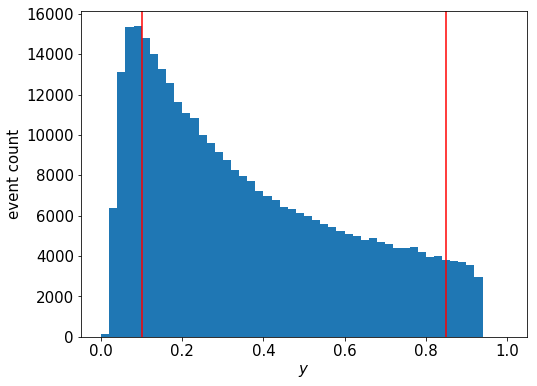

In [20]:
fig = plt.figure(figsize=(8,6))
plt.hist(ae0['y'], bins=50, range=(0,1))
plt.axvline(x=0.1, color='r')
plt.axvline(x=0.85, color='r')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('$y$', fontsize=15)
plt.ylabel('event count', fontsize=15)
plt.savefig('images/y_100.png', bbox_inches='tight')
ae0 = applyCut(ae0, '0.1 < y < 0.85', '0.1 < y < 0.85')

10 < electron pt < 30 139038  fraction kept: 50.7


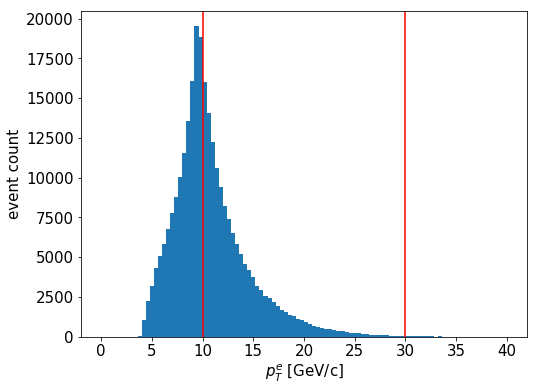

In [21]:
fig = plt.figure(figsize=(8,6))
plt.hist(ae0['electron_truthPt'], bins=100, range=(0,40))
plt.axvline(x=10, color='r')
plt.axvline(x=30, color='r')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('$p_T^e$ [GeV/c]', fontsize=15)
plt.ylabel('event count', fontsize=15)
plt.savefig('images/pte.png', bbox_inches='tight')
ae0 = applyCut(ae0, '10 < electron_truthPt < 30', '10 < electron pt < 30')

In [22]:
aj.eval('dphi = phi - electron_truthPhi - 3.1415926535', inplace=True)
aj0 = fix_dphi(aj)
aj0 = applyCut(aj0, 'Q2 > 100', 'Q2 > 100')
aj0 = applyCut(aj0, '0.1 < y < 0.85', '0.1 < y < 0.85')
aj0 = applyCut(aj0, '10 < electron_truthPt < 30', '10 < electron pt < 30')

Fixed dphi delta phi range
Q2 > 100 862909  fraction kept: 9.4
0.1 < y < 0.85 719434  fraction kept: 83.4
10 < electron pt < 30 334210  fraction kept: 46.5


nComponent > 2 120263  fraction kept: 36.0


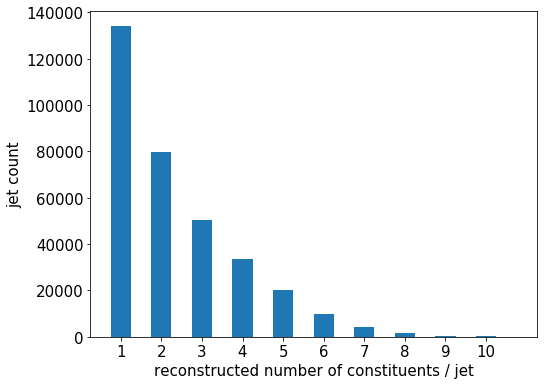

In [23]:
#aj0 = applyCut(aj0, 'matched_truthNComponent != 0', 'matched_truthNComponent != 0')
fig = plt.figure(figsize=(8,6))
plt.hist(aj0['nComponent'], range=(1,11), bins=20)
plt.xticks(np.arange(1.25,11.25,1), ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('reconstructed number of constituents / jet', fontsize=15)
plt.ylabel('jet count', fontsize=15)
plt.savefig('images/ncomp_100.png', bbox_inches='tight')
aj0 = applyCut(aj0, 'nComponent > 2', 'nComponent > 2')

In [24]:
def count_njet(df):
    max_njet = max(df['njets'])
    njets_passed_array = []
    jet_index = 0
    while (jet_index < len(df)):
        event_index = np.asarray(df['event'])[jet_index]
        njet = 1
        end_index = jet_index + max_njet - 1
        if end_index >= len(df) - 1:
            end_index = len(df) - 1
        for j in range(jet_index + 1, end_index + 1):
            event_index2 = np.asarray(df['event'])[j]
            if event_index2 != event_index:
                break
            njet += 1
        jet_index += njet
        njets_passed_array.extend([njet]*njet)
    return njets_passed_array

In [25]:
njets_passed_array = count_njet(aj0)
aj0['njets_passed_cut'] = njets_passed_array

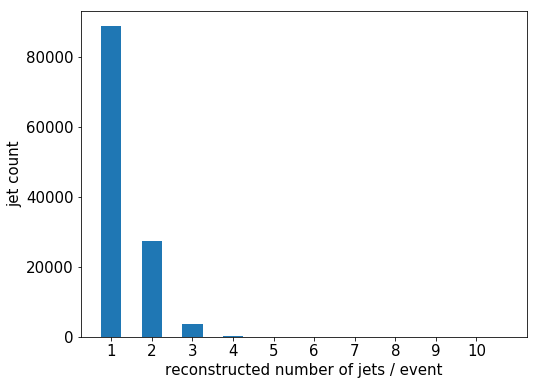

In [26]:
fig = plt.figure(figsize=(8,6))
plt.hist(aj0['njets_passed_cut'], range=(1,11), bins=20)
plt.xticks(np.arange(1.25,11.25,1), ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('reconstructed number of jets / event', fontsize=15)
plt.ylabel('jet count', fontsize=15)
plt.savefig('images/njet_100.png', bbox_inches='tight')

In [27]:
aj1 = applyCut(aj0, 'njets_passed_cut == 1', '1 jet / event')
aj2 = applyCut(aj0, 'njets_passed_cut == 2', '2 jets / event')

1 jet / event 88904  fraction kept: 73.9
2 jets / event 27366  fraction kept: 22.8


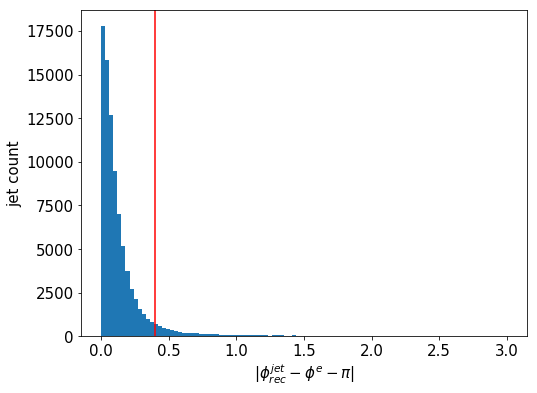

In [28]:
fig = plt.figure(figsize=(8,6))
plt.hist(aj1['abs_dphi'], bins=100, range=(0,3.0))
plt.axvline(x=0.4, color='r')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('$|\phi^{jet}_{rec} - \phi^e - \pi|$', fontsize=15)
plt.ylabel('jet count', fontsize=15)
plt.savefig('images/dphi1_2part_100.png', bbox_inches='tight')

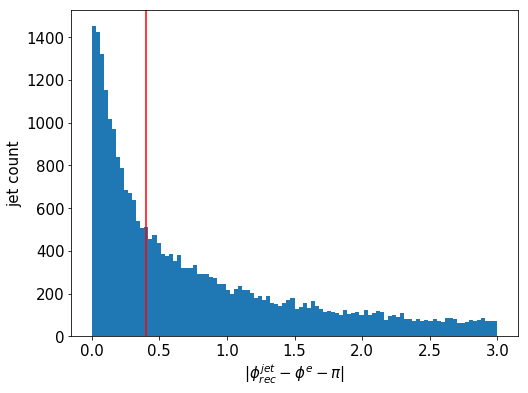

In [29]:
fig = plt.figure(figsize=(8,6))
plt.hist(aj2['abs_dphi'], bins=100, range=(0,3.0))
plt.axvline(x=0.4, color='r')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('$|\phi^{jet}_{rec} - \phi^e - \pi|$', fontsize=15)
plt.ylabel('jet count', fontsize=15)
plt.savefig('images/dphi2_part_100.png', bbox_inches='tight')

In [30]:
aj1_dphi = applyCut(aj1, 'abs_dphi < 0.4', 'abs_dphi < 0.4')
aj2_dphi = applyCut(aj2, 'abs_dphi < 0.4', 'abs_dphi < 0.4')

abs_dphi < 0.4 81459  fraction kept: 91.6
abs_dphi < 0.4 12186  fraction kept: 44.5


In [31]:
radii = [0, 10, 20, 30, 40]
r_labels = ['$0$','$10$','$20$','$30$','$40$']
radii_s = [0, 5, 10, 15, 20]
r_labels_s = ['$0$','$5$','$10$','$15$','$20$']
angles = [90, 139.604937421, 164.585373193, 174.299529125, 177.90141703, 180, 182.09858297, 185.700470875, 195.414626807,
          220.395062579, 270, 319.604937421, 344.585373193, 354.299529125, 357.90141703, 360]
eta_labels=['0','-1','-2','-3','','','','-3','-2','-1','0','1','2','3','']
nr = 40
nr_s = 20
ntheta = 90

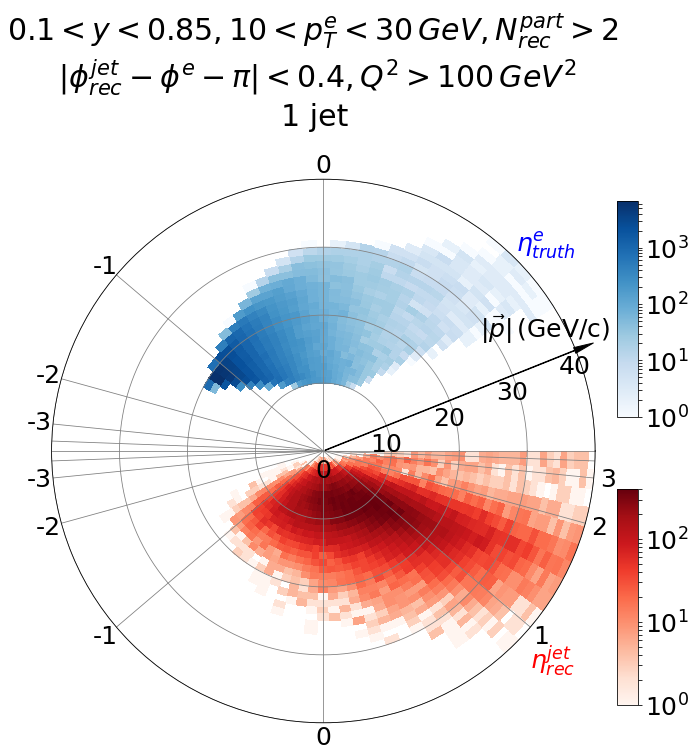

In [35]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(111, polar=True)

r_edges = np.linspace(0, nr, nr + 1)
theta_edges = np.linspace(0, 2*np.pi, ntheta + 1)
H_e = plt.hist2d(ae0['electron_truthP'], ae0['electron_truthTheta'], [r_edges, theta_edges])[0]
H_q = plt.hist2d(aj1_dphi['p'], aj1_dphi['theta_neg'], [r_edges, theta_edges])[0]
ax1.cla()

Theta, R = np.meshgrid(theta_edges, r_edges)
im_e = ax1.pcolormesh(Theta, R, H_e, cmap='Blues', norm=LogNorm())
im_q = ax1.pcolormesh(Theta, R, H_q, cmap='Reds', norm=LogNorm())
ax1.set_rgrids(radii, labels=r_labels, fontsize=25)
ax1.set_thetagrids(angles, labels=eta_labels, fontsize=25)
ax1.grid(color='grey')
cbar_e = fig.colorbar(im_e, shrink=0.7, pad=0.01, cax=plt.axes([0.92, 0.55, 0.03, 0.3]))
cbar_e.ax.tick_params(labelsize=25)
cbar_q = fig.colorbar(im_q, shrink=0.7, pad=0.01, cax=plt.axes([0.92, 0.15, 0.03, 0.3]))
cbar_q.ax.tick_params(labelsize=25)
fig.text(0.78,0.78,'$\eta^{e}_{truth}$',fontsize=25, color='b')
fig.text(0.8,0.2,'$\eta^{jet}_{rec}$',fontsize=25, color='r')
ax1.annotate('', xy=(1,0.7), xycoords='axes fraction', xytext=(0.5,0.5), 
    arrowprops=dict(arrowstyle="Simple,tail_width=0.05,head_width=0.6,head_length=2", color='k'))
fig.text(0.73,0.66, r'$|\vec{p}| \, \mathrm{(GeV/c)}$',fontsize=25, color='k')
fig.suptitle('$0.1 < y < 0.85, 10 < p_T^e < 30 \, GeV, N^{part}_{rec} > 2$ \n $|\phi^{jet}_{rec} - \phi^e - \pi| < 0.4, Q^2 > 100 \, GeV^2$ \n'+'1 jet',fontsize=30, y=1.12)
fig.savefig('images/polar1_727_100.png', bbox_inches='tight')

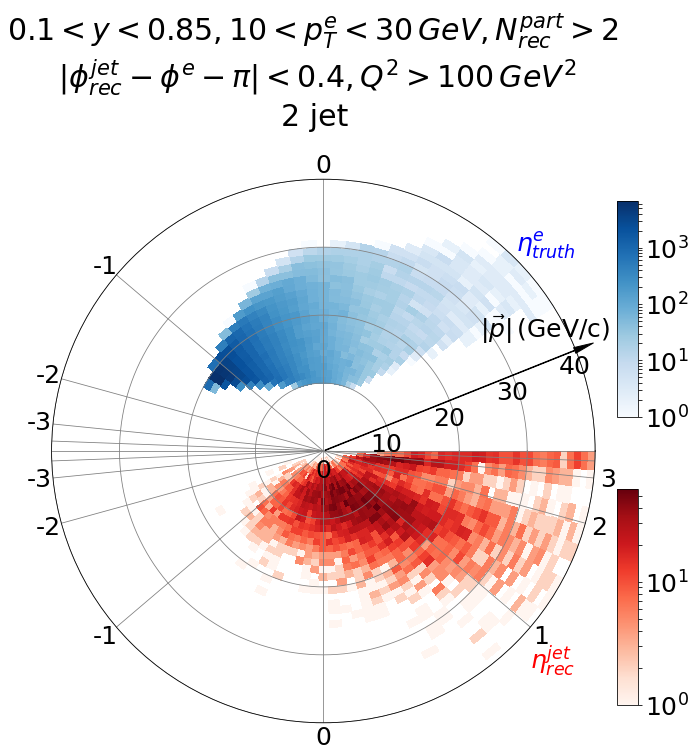

In [36]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(111, polar=True)

r_edges = np.linspace(0, nr, nr + 1)
theta_edges = np.linspace(0, 2*np.pi, ntheta + 1)
H_e = plt.hist2d(ae0['electron_truthP'], ae0['electron_truthTheta'], [r_edges, theta_edges])[0]
H_q = plt.hist2d(aj2_dphi['p'], aj2_dphi['theta_neg'], [r_edges, theta_edges])[0]
ax1.cla()

Theta, R = np.meshgrid(theta_edges, r_edges)
im_e = ax1.pcolormesh(Theta, R, H_e, cmap='Blues', norm=LogNorm())
im_q = ax1.pcolormesh(Theta, R, H_q, cmap='Reds', norm=LogNorm())
ax1.set_rgrids(radii, labels=r_labels, fontsize=25)
ax1.set_thetagrids(angles, labels=eta_labels, fontsize=25)
ax1.grid(color='grey')
cbar_e = fig.colorbar(im_e, shrink=0.7, pad=0.01, cax=plt.axes([0.92, 0.55, 0.03, 0.3]))
cbar_e.ax.tick_params(labelsize=25)
cbar_q = fig.colorbar(im_q, shrink=0.7, pad=0.01, cax=plt.axes([0.92, 0.15, 0.03, 0.3]))
cbar_q.ax.tick_params(labelsize=25)
fig.text(0.78,0.78,'$\eta^{e}_{truth}$',fontsize=25, color='b')
fig.text(0.8,0.2,'$\eta^{jet}_{rec}$',fontsize=25, color='r')
ax1.annotate('', xy=(1,0.7), xycoords='axes fraction', xytext=(0.5,0.5), 
    arrowprops=dict(arrowstyle="Simple,tail_width=0.05,head_width=0.6,head_length=2", color='k'))
fig.text(0.73,0.66, r'$|\vec{p}| \, \mathrm{(GeV/c)}$',fontsize=25, color='k')
fig.suptitle('$0.1 < y < 0.85, 10 < p_T^e < 30 \, GeV, N^{part}_{rec} > 2$ \n $|\phi^{jet}_{rec} - \phi^e - \pi| < 0.4, Q^2 > 100 \, GeV^2$ \n'+'2 jet',fontsize=30, y=1.12)
fig.savefig('images/polar2_727_100.png', bbox_inches='tight')